<a href="https://colab.research.google.com/github/Raiden-Makoto/Genshinfy-UwU/blob/main/VGG19/VGG19_StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import keras
from keras import layers, optimizers
from keras.applications import vgg19
import keras.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
TOTAL_VAR_WT = 1e-6
STY_WT = 1e-6
CONT_WT = 2.5e-8

WIDTH, HEIGHT = 480, 480 #size of the images in the dataset

In [4]:
!git clone https://github.com/Raiden-Makoto/Genshinfy-UwU

Cloning into 'Genshinfy-UwU'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 216 (delta 52), reused 131 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 40.52 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [5]:
%cd Genshinfy-UwU

/content/Genshinfy-UwU


Let's just test on some sample photos.

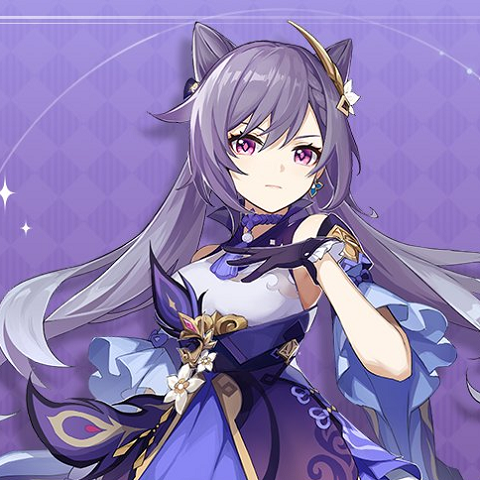

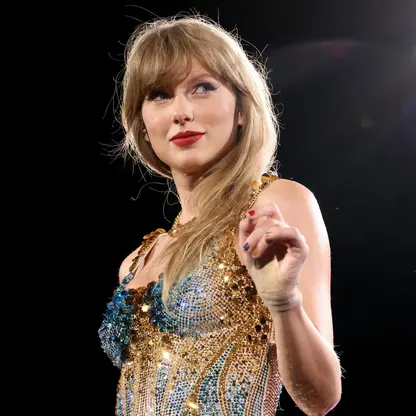

In [6]:
from IPython.display import Image, display

display(Image('./GenshinCharacters/Keqing.png'))
display(Image('./Taylor Swift.png'))

## Functions to Preprocess the Images

In [7]:
def preprocess_image(path):
    img = utils.load_img(path, target_size=(HEIGHT, WIDTH))
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [8]:
def deprocess_image(x):
    x = x.reshape((HEIGHT, WIDTH, 3))
    x[:, :, 0] += 103.939 # un-scale
    x[:, :, 1] += 116.779 # un-scale
    x[:, :, 2] += 123.68 # un-scale
    x = x[:, :, ::-1] # BGR to RGB format
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Style Transfer Loss

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [10]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = HEIGHT * WIDTH
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [11]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [12]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : HEIGHT - 1, : WIDTH - 1, :] - x[:, 1:, : WIDTH - 1, :]
    )
    b = tf.square(
        x[:, : HEIGHT - 1, : WIDTH - 1, :] - x[:, : HEIGHT- 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## VGG19 Model
Uses pre-trained `imagenet` weights

In [21]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [22]:
feature_extractor.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"

In [24]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    # add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + CONT_WT * content_loss(
        base_image_features, combination_features
    )

    # add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (STY_WT / len(style_layer_names)) * sl

    # total variation loss
    loss += TOTAL_VAR_WT * total_variation_loss(combination_image)
    return loss

In [25]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Training Loop

In [26]:
optimizer = optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

In [27]:
style_reference_image = preprocess_image("./GenshinCharacters/Lumine.png")
base_image = preprocess_image("./Taylor Swift.png")
combination_image = tf.Variable(preprocess_image("./Taylor Swift.png"))

In [29]:
for i in range(1, 4000 + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = "generated_at_iteration_%d.png" % i
        utils.save_img(fname, img)

Iteration 100: loss=3619.19
Iteration 200: loss=2804.16
Iteration 300: loss=2475.78
Iteration 400: loss=2295.56
Iteration 500: loss=2178.50
Iteration 600: loss=2095.00
Iteration 700: loss=2031.11
Iteration 800: loss=1980.48
Iteration 900: loss=1939.42
Iteration 1000: loss=1905.18
Iteration 1100: loss=1875.96
Iteration 1200: loss=1850.72
Iteration 1300: loss=1828.72
Iteration 1400: loss=1809.36
Iteration 1500: loss=1792.13
Iteration 1600: loss=1776.75
Iteration 1700: loss=1762.76
Iteration 1800: loss=1750.10
Iteration 1900: loss=1738.51
Iteration 2000: loss=1727.80
Iteration 2100: loss=1717.91
Iteration 2200: loss=1708.78
Iteration 2300: loss=1700.30
Iteration 2400: loss=1692.40
Iteration 2500: loss=1685.10
Iteration 2600: loss=1678.31
Iteration 2700: loss=1671.96
Iteration 2800: loss=1666.03
Iteration 2900: loss=1660.51
Iteration 3000: loss=1655.34
Iteration 3100: loss=1650.47
Iteration 3200: loss=1645.91
Iteration 3300: loss=1641.65
Iteration 3400: loss=1637.63
Iteration 3500: loss=16

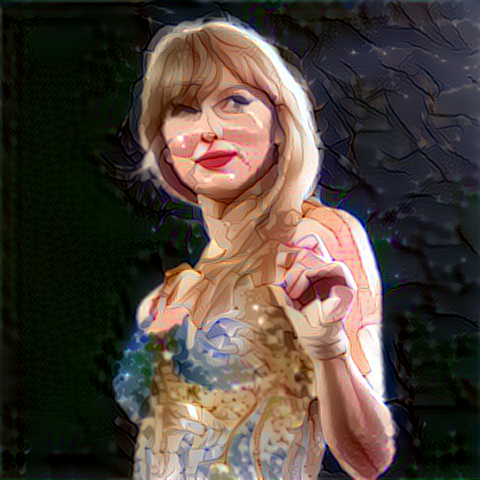

In [30]:
display(Image('./generated_at_iteration_4000.png'))